In [183]:
import json, os, re, networkx
from konlpy.utils import pprint
from konlpy.tag import Twitter
#from ckonlpy.tag import Twitter
#tw = Twitter()
import datetime

In [184]:
import sqlite3, io
import pandas as pd
from pandas import Series, DataFrame
from dateutil.parser import parse

In [185]:
con = sqlite3.connect("./data/convert.db")
cursor = con.cursor()
con.text_factory = bytes
df = pd.read_sql("SELECT * FROM content", con, index_col=None)
df = df.iloc[1:-1]
corpus = df.to_dict('records')

In [186]:
#따로 전처리할 필요 X
def preprocessing(content):
    #content = re.sub('[a-zA-Z]', '', content)
    content = re.sub('/(<([^>])>)/ig', '', content)
    content = re.sub('\\t', '', content)
    content = re.sub('\\n', '', content)
    content = re.sub('[\{\}\[\]\/?,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\")]', '', content)
    content = ' '.join(content.split())
    
    return content

In [187]:
#따로 토크나이징할 필요 X
def origin_tokenizing(content): #입력 문장 리스트를 토크나이징한다. Kkma는 pos로 분리하고, OS, NNG, NP만 빼내는 것이 좋다.
    featurelist = []
    tw = Twitter()
    for term in tw.pos(content):
        featurelist.append(term)
    return featurelist

In [2]:
class RawSentence: #문자열에 대한 처리
    def __init__(self, textIter):
        if type(textIter) == str: 
            self.textIter = textIter.split('\n')
        else: 
            self.textIter = textIter
        self.rgxSplitter = re.compile('([!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in self.textIter:
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a, b: a + b, ch[::2], ch[1::2]):
                if not s: 
                    continue
                yield s


In [3]:
class RawSentenceReader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.rgxSplitter = re.compile('([!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a, b: a + b, ch[::2], ch[1::2]):
                if not s: 
                    continue
                yield s


In [188]:
utf_corpus = []
for i, data in enumerate(corpus):
    try:
        dd = dict()
        dd['title'] = data['title'].decode('utf-8')
        dd['content'] = data['content'].decode('utf-8')
        dd['link'] = data['link'].decode('utf-8')
        #dd['publish'] = datetime.datetime.strptime(data['publish'].decode('utf-8'), '%Y-%m-%d')
        dd['publish'] = data['publish'].decode('utf-8')
        dd['provider'] = data['provider'].decode('utf-8')
        #dd['tokens'] = origin_tokenizing(preprocessing(dd['content']))
    except Exception as err:
        print(i, err)
    finally:
        if len(dd.keys()) == 5: #tokens == 6, but so slow
            utf_corpus.append(dd)

In [189]:
class Docu:
    def __init__(self, content, link, provider, publish, title): #, tokens):
        self.content = content
        self.link = link
        self.provider = provider
        #self.publish = publish
        #self.publish = parse(publish)
        self.publish = datetime.datetime.strptime(publish, '%Y-%m-%d')
        self.title = title
        #self.tokens = tokens
    def __repr__(self):
        return repr((self.content, self.link, self.provider, self.publish, self.title))#, self.tokens))

In [190]:
#문서모음 객체화(정렬을 위함)
docments = list()
for i, data in enumerate(utf_corpus):
    docments.append(Docu(data['content'], data['link'], data['provider'], data['publish'], data['title']))#, data['tokens']))

In [191]:
#객체 날짜순 정렬(오름차순)
result = sorted(docments, key=lambda docu: docu.publish)
#정렬 확인
#for data in result:
#    print(data.publish.date())

In [192]:
#월별 데이터 묶음
predata = result[0]
datecorpus = {}
datecorpus[str(predata.publish.strftime("%Y-%m"))] = {'string' : predata.content + "\n"}

for i in range(1, len(result)):
    if result[i].publish.strftime("%Y-%m") == predata.publish.strftime("%Y-%m"):
        try:
            datecorpus[str(result[i].publish.strftime("%Y-%m"))]['string'] += str(result[i].content + "\n")
            #print(result[i].publish.date())
        except KeyError as e:
            datecorpus[str(result[i].publish.strftime("%Y-%m"))] = {'string' : str(result[i].content + "\n")}
            #print(e)
    predata = result[i]
    

## TextRank

In [206]:
class RawTagger:
    def __init__(self, textIter, tagger = None):
        if tagger:
            self.tagger = tagger
        else :
            from konlpy.tag import Twitter
            self.tagger = Twitter()
        if type(textIter) == str:
            self.textIter = textIter.split('\n')
        else: 
            self.textIter = textIter
        self.rgxSplitter = re.compile('([!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in self.textIter:
            if len(line) == 0:
                continue
            ch = self.rgxSplitter.split(line)
            if len(ch) == 1:
                ch.append('.')
            for s in map(lambda a,b:a+b, ch[::2], ch[1::2]):
                if not s: continue
                yield self.tagger.pos(s)


In [194]:
class RawTaggerReader:
    def __init__(self, filepath, tagger = None):
        if tagger:
            self.tagger = tagger
        else :
            from konlpy.tag import Twitter
            self.tagger = Twitter()
        self.filepath = filepath
        self.rgxSplitter = re.compile('([!?:](?:["\']|(?![0-9])))')
 
    def __iter__(self):
        for line in open(self.filepath, encoding='utf-8'):
            ch = self.rgxSplitter.split(line)
            for s in map(lambda a,b:a+b, ch[::2], ch[1::2]):
                if not s: continue
                yield self.tagger.pos(s)


In [195]:
class TextRank:
    def __init__(self, **kargs):
        self.graph = None
        self.window = kargs.get('window', 5)
        self.coef = kargs.get('coef', 1.0)
        self.threshold = kargs.get('threshold', 0.005)
        self.dictCount = {}
        self.dictBiCount = {}
        self.dictNear = {}
        self.nTotal = 0
 
 
    def load(self, sentenceIter, wordFilter = None):
        def insertPair(a, b):
            if a > b: a, b = b, a
            elif a == b: return
            self.dictBiCount[a, b] = self.dictBiCount.get((a, b), 0) + 1
 
        def insertNearPair(a, b):
            self.dictNear[a, b] = self.dictNear.get((a, b), 0) + 1
 
        for sent in sentenceIter:
            for i, word in enumerate(sent):
                if wordFilter and not wordFilter(word): continue
                self.dictCount[word] = self.dictCount.get(word, 0) + 1
                self.nTotal += 1
                if i - 1 >= 0 and (not wordFilter or wordFilter(sent[i-1])): insertNearPair(sent[i-1], word)
                if i + 1 < len(sent) and (not wordFilter or wordFilter(sent[i+1])): insertNearPair(word, sent[i+1])
                for j in range(i+1, min(i+self.window+1, len(sent))):
                    if wordFilter and not wordFilter(sent[j]): continue
                    if sent[j] != word: insertPair(word, sent[j])
 
    def loadSents(self, sentenceIter, tokenizer = None):
        import math
        def similarity(a, b):
            n = len(a.intersection(b))
            return n / float(len(a) + len(b) - n) / (math.log(len(a)+1) * math.log(len(b)+1))
 
        if not tokenizer: rgxSplitter = re.compile('[\\s.,:;-?!()"\']+')
        sentSet = []
        for sent in filter(None, sentenceIter):
            if type(sent) == str:
                if tokenizer: s = set(filter(None, tokenizer(sent)))
                else: s = set(filter(None, rgxSplitter.split(sent)))
            else: s = set(sent)
            if len(s) < 2: continue
            self.dictCount[len(self.dictCount)] = sent
            sentSet.append(s)
 
        for i in range(len(self.dictCount)):
            for j in range(i+1, len(self.dictCount)):
                s = similarity(sentSet[i], sentSet[j])
                if s < self.threshold: continue
                self.dictBiCount[i, j] = s
 
    def getPMI(self, a, b):
        import math
        co = self.dictNear.get((a, b), 0)
        if not co: return None
        return math.log(float(co) * self.nTotal / self.dictCount[a] / self.dictCount[b])
 
    def getI(self, a):
        import math
        if a not in self.dictCount: return None
        return math.log(self.nTotal / self.dictCount[a])
 
    def build(self):
        self.graph = networkx.Graph()
        self.graph.add_nodes_from(self.dictCount.keys())
        for (a, b), n in self.dictBiCount.items():
            self.graph.add_edge(a, b, weight = n*self.coef + (1-self.coef))
 
    def rank(self):
        return networkx.pagerank(self.graph, weight='weight')
 
    def extract(self, ratio = 0.1):
        ranks = self.rank()
        cand = sorted(ranks, key=ranks.get, reverse=True)[:int(len(ranks) * ratio)]
        pairness = {}
        startOf = {}
        tuples = {}
        complex_pmi = []
        for k in cand:
            tuples[(k,)] = self.getI(k) * ranks[k]
            for l in cand:
                if k == l: continue
                pmi = self.getPMI(k, l)
                if pmi: pairness[k, l] = pmi
 
        for (k, l) in sorted(pairness, key=pairness.get, reverse=True):
            temp = (k[0]+l[0], pairness[k, l])
            complex_pmi.append(temp)
            if k not in startOf: startOf[k] = (k, l)
        return complex_pmi

        '''for (k, l), v in pairness.items():
            pmis = v
            rs = ranks[k] * ranks[l]
            path = (k, l)
            tuples[path] = pmis / (len(path) - 1) * rs ** (1 / len(path)) * len(path)
            last = l
            while last in startOf and len(path) < 7:
                if last in path: break
                pmis += pairness[startOf[last]]
                last = startOf[last][1]
                rs *= ranks[last]
                path += (last,)
                tuples[path] = pmis / (len(path) - 1) * rs ** (1 / len(path)) * len(path)
 
        used = set()
        both = {}
        for k in sorted(tuples, key=tuples.get, reverse=True):
            if used.intersection(set(k)): continue
            both[k] = tuples[k]
            for w in k: used.add(w)
 
        #for k in cand:
        #    if k not in used or True: both[k] = ranks[k] * self.getI(k)
 
        return both'''
 
    def summarize(self, ratio = 0.333):
        r = self.rank()
        ks = sorted(r, key=r.get, reverse=True)[:int(len(r)*ratio)]
        return ' '.join(map(lambda k:self.dictCount[k], sorted(ks)))


In [196]:
stopword = set([
                ('있', 'Verb'), ('하', 'Verb'), ('할', 'Verb'), ('되', 'Verb'), ('없', 'Verb'), 
                ('위해', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective'),('없다', 'Adjective'), ('통해', 'Noun'), 
                ('그럴', 'Adjective'), ('를', 'Noun'), ('는', 'Noun'), ('때문', 'Noun'), ('와', 'Noun'), ('전혀', 'Noun'), ('www','alpha')
               ])

In [207]:
sorted_word = {}
for date in list(datecorpus.keys()):
    tr = TextRank(window=1, coef=1, threshold = 5)
    %time tr.load(RawTagger(datecorpus[date]['string']), lambda w: w not in stopword and (w[1] in ('Noun', 'Adjective', 'Alpha', 'Number')))
    tr.build()
    datecorpus[date]['pmi'] = tr.extract(0.4)
    for data in datecorpus[date]['pmi']:
        try:
            sorted_word[data[0]][date] = data[1]
        except KeyError as e:
            sorted_word[data[0]] = {}
            sorted_word[data[0]][date] = data[1]

CPU times: user 8.76 s, sys: 32 ms, total: 8.79 s
Wall time: 8.43 s
CPU times: user 7.11 s, sys: 48 ms, total: 7.16 s
Wall time: 6.87 s
CPU times: user 6.74 s, sys: 32 ms, total: 6.78 s
Wall time: 6.5 s
CPU times: user 5.46 s, sys: 20 ms, total: 5.48 s
Wall time: 5.27 s
CPU times: user 6.83 s, sys: 28 ms, total: 6.86 s
Wall time: 6.56 s
CPU times: user 6.92 s, sys: 40 ms, total: 6.96 s
Wall time: 6.67 s
CPU times: user 8.44 s, sys: 52 ms, total: 8.5 s
Wall time: 8.14 s
CPU times: user 8.04 s, sys: 52 ms, total: 8.1 s
Wall time: 7.79 s
CPU times: user 7.43 s, sys: 52 ms, total: 7.48 s
Wall time: 7.19 s
CPU times: user 6.31 s, sys: 28 ms, total: 6.34 s
Wall time: 6.09 s
CPU times: user 7.01 s, sys: 36 ms, total: 7.05 s
Wall time: 6.74 s
CPU times: user 5.48 s, sys: 20 ms, total: 5.5 s
Wall time: 5.25 s
CPU times: user 5.93 s, sys: 44 ms, total: 5.98 s
Wall time: 5.75 s
CPU times: user 7.96 s, sys: 40 ms, total: 8 s
Wall time: 7.66 s
CPU times: user 7.38 s, sys: 44 ms, total: 7.42 s
Wall 

CPU times: user 5.62 s, sys: 20 ms, total: 5.64 s
Wall time: 5.39 s
CPU times: user 5.47 s, sys: 36 ms, total: 5.51 s
Wall time: 5.3 s
CPU times: user 5.76 s, sys: 56 ms, total: 5.81 s
Wall time: 5.55 s
CPU times: user 6.02 s, sys: 44 ms, total: 6.06 s
Wall time: 5.81 s
CPU times: user 9.84 s, sys: 48 ms, total: 9.89 s
Wall time: 9.46 s
CPU times: user 9.08 s, sys: 48 ms, total: 9.13 s
Wall time: 8.76 s
CPU times: user 8.38 s, sys: 52 ms, total: 8.43 s
Wall time: 8.07 s
CPU times: user 8.08 s, sys: 84 ms, total: 8.17 s
Wall time: 7.83 s
CPU times: user 8.52 s, sys: 44 ms, total: 8.56 s
Wall time: 8.22 s
CPU times: user 7.12 s, sys: 16 ms, total: 7.13 s
Wall time: 6.84 s
CPU times: user 7.29 s, sys: 48 ms, total: 7.34 s
Wall time: 7.02 s
CPU times: user 6.91 s, sys: 32 ms, total: 6.94 s
Wall time: 6.69 s
CPU times: user 8.51 s, sys: 56 ms, total: 8.57 s
Wall time: 8.23 s
CPU times: user 7.94 s, sys: 52 ms, total: 8 s
Wall time: 7.69 s
CPU times: user 7.45 s, sys: 48 ms, total: 7.5 s
Wal

In [200]:
len(sorted_word)

0

In [426]:
#다시 짜자 좀 쉬고...
'''
a = list(datecorpus.keys())
predate = datecorpus[a[0]]
for i in range(1, len(a)):
    for c_word in datecorpus[a[i]]['pmi']:
        for j, pre_c_word in enumerate(predate['pmi']):
            if str(pre_c_word[0]) == str(c_word[0]):
                del predate['pmi'][j]
    datecorpus[a[i]]['pmi'] += predate['pmi']
    #
    print(len(datecorpus[a[i]]['pmi']))
    predate = a[a[i]]
'''
#시간 순에 따른 단어의 PMI 정렬은 한 그래프안의 표현하는데 문제가 있다.

"\na = list(datecorpus.keys())\npredate = datecorpus[a[0]]\nfor i in range(1, len(a)):\n    for c_word in datecorpus[a[i]]['pmi']:\n        for j, pre_c_word in enumerate(predate['pmi']):\n            if str(pre_c_word[0]) == str(c_word[0]):\n                del predate['pmi'][j]\n    datecorpus[a[i]]['pmi'] += predate['pmi']\n    #\n    print(len(datecorpus[a[i]]['pmi']))\n    predate = a[a[i]]\n"

In [31]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
a = fm.FontProperties(fname=font_list[0])
a.get_name()
font_list

['/usr/share/fonts/truetype/nanum/NanumGothic_Coding.ttf',
 '/usr/share/fonts/truetype/nanum-eco/NanumGothicEcoBold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-ExtraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-RI.ttf',
 '/usr/share/fonts/truetype/droid/DroidSansThai.ttf',
 '/usr/share/fonts/truetype/droid/DroidSansEthiopic-Bold.ttf',
 '/usr/share/fonts/truetype/tlwg/TlwgTypo-Bold.ttf',
 '/usr/share/fonts/truetype/freefont/FreeSerifItalic.ttf',
 '/usr/share/fonts/truetype/droid/DroidSansHebrew-Bold.ttf',
 '/usr/share/fonts/truetype/droid/DroidSansMono.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf',
 '/usr/share/fonts/truetype/freefont/FreeSerifBold.ttf',
 '/usr/share/fonts/truetype/ttf-punjabi-fonts/lohit_pa.ttf',
 '/usr/share/fonts/truetype/tlwg/Umpush.ttf',
 '/usr/share/fonts/truetype/tlwg/Kinnari-Oblique.ttf',
 '/usr/share/fonts/truetype/tlwg/Waree-Bold.ttf',
 '/usr/share/fonts/truetyp

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc #TSNE 그림에서 한글이 깨지는 문제를 해결해준다.
font_fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'     # A font of your choice
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (80,40)

In [33]:
a = list(sorted_word.keys())
date = list(datecorpus.keys())
for i, word in enumerate(sorted_word):
    #if i == 100 : break; #Graph Test
    dates = [mpl.dateutil.parser.parse(day) for day in list(sorted_word[a[i]].keys())]
    values = sorted_word[a[i]].values()
    plt.plot(dates, values, 'bs--' ,label=word)
    #plt.legend(loc='upper left')
    mindate = mpl.dateutil.parser.parse(date[0])
    maxdate = mpl.dateutil.parser.parse(date[-1])
    plt.xlim(mindate, maxdate)
    #plt.xticks(list(datecorpus.keys()))
    plt.ylim(-5, 20)
    plt.xlabel('Date')
    plt.ylabel('Complex Word PMI')
    plt.title(word)
    fig = plt.gcf() #변경한 곳
    fig.savefig('./word_graph/'+word+'.png') #변경한 곳
    plt.close()

In [74]:
mindate

datetime.datetime(2015, 5, 4, 0, 0)

In [76]:
maxdate

datetime.datetime(2015, 8, 14, 0, 0)

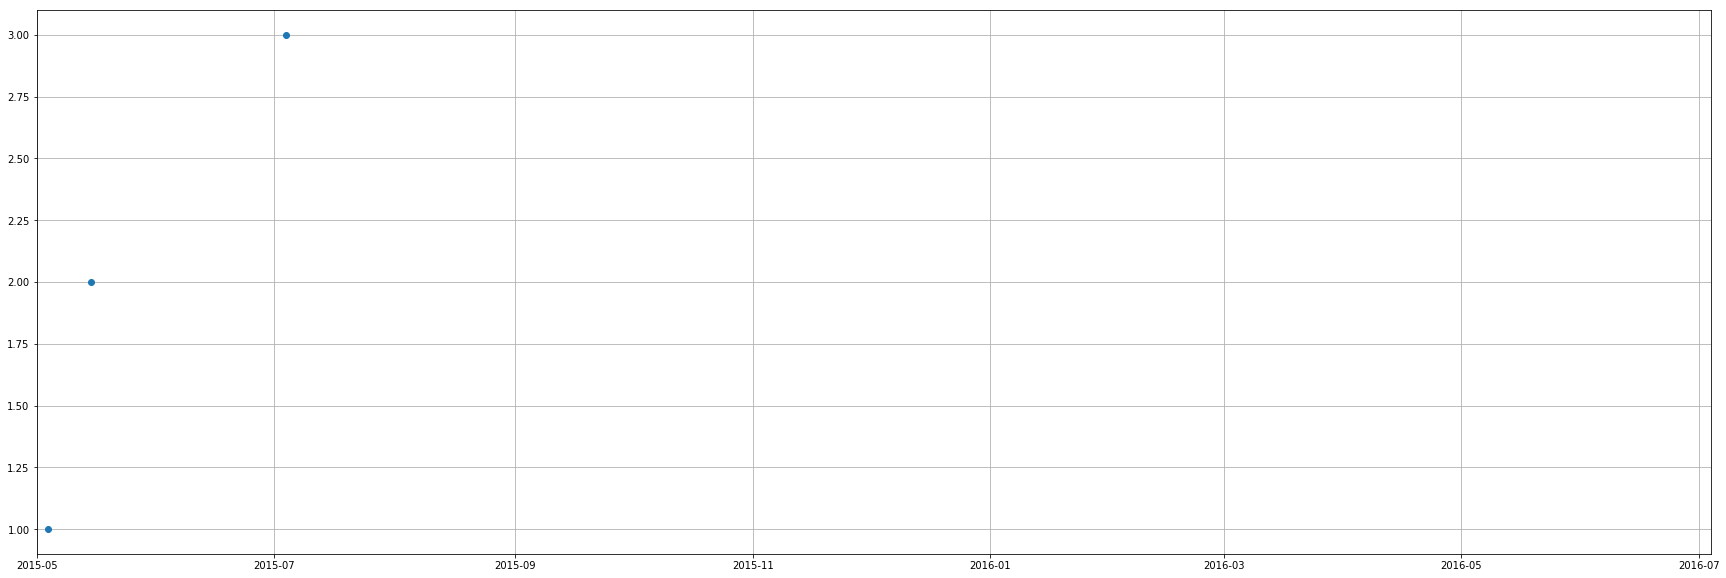

In [36]:
plt.rcParams["figure.figsize"] = (30,10)
plt.xlim(mpl.dateutil.parser.parse('2015-05-01'), mpl.dateutil.parser.parse('2016-07-04'))
plt.plot_date(dates, [1,2,3])